## Data preparation for Steam datasets

In [1]:
# import libraries
import pandas as pd
import string
import nltk
import re
import ast
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

### PLAYTIME DATA PREP

In [78]:
# load steam_playtime.csv
users_df = pd.read_csv('../data/steam_playtime.csv')

# drop counterstrike i.e. drop rows where appid is 730, 10 or 240
users_df = users_df[~users_df['appid'].isin([730, 10, 240])]

# drop user playtimes over a 150k minutes
# probably people who mine in-game content using scripts
users_df = users_df[users_df['playtime_forever'] < 150000]

# remove user playtimes under 60 minutes
users_df = users_df[users_df['playtime_forever'] > 60]

# drop playtime_2weeks column, not much there
users_df = users_df.drop(columns = ['playtime_2weeks'])

In [79]:
len(users_df)

1051857

In [80]:
len(users_df['steam_id'].unique())

12568

In [81]:
users_df['playtime_forever'].mean()

2159.7241155404204

In [82]:
users_df['playtime_forever'].median()

328.0

#### DATA EXPLORATION

<AxesSubplot:>

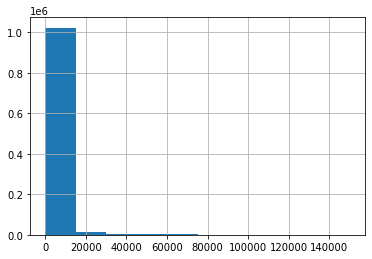

In [83]:
users_df.sort_values('playtime_forever', ascending=False)['playtime_forever'].hist()

In [84]:
import seaborn as sns

In [85]:
playtimes = users_df.sort_values('playtime_forever', ascending=False).reset_index()

In [86]:
playtimetotal = users_df.groupby('appid').sum().sort_values('playtime_forever', ascending=False).reset_index()

<AxesSubplot:>

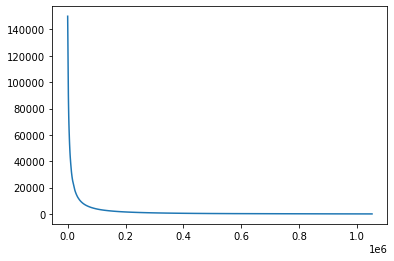

In [87]:
playtimes['playtime_forever'].plot()

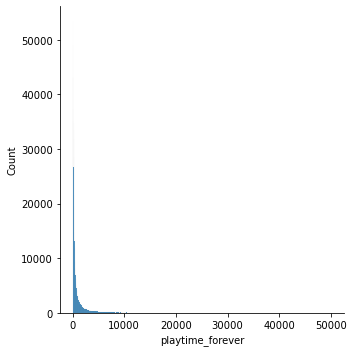

In [74]:
test = sns.displot(playtimes['playtime_forever'])

In [10]:
#test.savefig('out.png')

### GAME DATA PREP

In [11]:
# load steam_app_metadata.csv
games_df = pd.read_csv('../data/steam_app_metadata.csv')

#### one hot encode categories and genres

In [12]:
# make categories and genres into lists
games_df['categories'] = games_df['categories'].apply(ast.literal_eval)
games_df['genres'] = games_df['genres'].apply(ast.literal_eval)

In [13]:
# multilabel binarizer
mlb = MultiLabelBinarizer()

In [14]:
# encode categories 
games_df = games_df.join(pd.DataFrame(mlb.fit_transform(games_df.pop('categories')),
                          columns=mlb.classes_,
                          index=games_df.index))

In [15]:
# encode genres
games_df = games_df.join(pd.DataFrame(mlb.fit_transform(games_df.pop('genres')),
                          columns=mlb.classes_,
                          index=games_df.index))

#### process description column NLP style

In [16]:
# fill 'description' column NaN with empty string
games_df['description'] = games_df['description'].fillna('')

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
porter = PorterStemmer()

In [18]:
# function to clean text
def clean_text(text):
    # remove tags
    text = re.sub(r'<.*?>',' ',text)
    # remove URL links
    text = re.sub(r'http\S+', ' ', text)
    # remove non-breaking space
    text = text.replace(u'\xa0', u' ')
    # remove hex
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'[0-9]+', '', text)
    # make lowercase
    text = text.lower()
    # tokenize text
    tokens = nltk.word_tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if w not in stopwords]
    # stem words
    tokens = [porter.stem(w) for w in tokens]
    # make tokens into string
    text = ' '.join(tokens)
    # return clean text
    return text

In [19]:
# apply clean_text function to description column
games_df['description'] = games_df['description'].apply(clean_text)

In [20]:
# make description column into type string, otherwise tfidf cries
games_df['description'] = games_df['description'].astype(str)

In [21]:
# instantiate tfidfvectorizer
tfidf = TfidfVectorizer(max_features=1500, lowercase=False, min_df=5, ngram_range=(1,3))

In [22]:
# fit tfidfvectorizer to description column
tfidf_matrix = tfidf.fit_transform(games_df['description'])

In [23]:
# make matrix into dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

/home/berry/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
games_df = pd.concat([games_df, tfidf_df], axis=1)

In [25]:
games_df.shape

(23045, 1578)

#### Save some dataframes and other stuff

In [26]:
# make a dataframe from appid, name, developer and publisher. for our recommendations
# i have to go by location because 'name' is possibly a tf-idf term now
gameinfo_df = games_df.iloc[:, [0,1,3,4]]

In [27]:
# save gameinfo_df to csv
gameinfo_df.to_csv('../data/steam_gameinfo.csv', index=False)

In [28]:
# drop rows from users_df where appid is not in games_df
# play time for games is still in user profiles even if a game is no longer on steam
users_df = users_df[users_df['appid'].isin(games_df['appid'])]

In [29]:
# save users_df to csv
users_df.to_csv('../data/steam_playtime_clean.csv', index=False)

In [30]:
# drop name, developer and publisher from games_df
games_df = games_df.drop(columns = ['name', 'developer', 'publisher', 'description'])

In [31]:
# save games_df to csv
games_df.to_csv('../data/steam_app_metadata_clean.csv', index=False)